In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict
pd.options.display.max_columns = 100
%matplotlib inline

# Bill Involvement Model
This is a very simple model. It will predict voting behavior based on a member's bill involvement (were they cosponsors/have an ammendement accepted)
## Feature Construction

In [18]:
# bills file
df_bills = pd.read_csv('../data/propublica/billsfull_model.csv', encoding = 'latin1')
columns = ['bill_id','cosponsor', 'dsponsor', 'rsponsor', 'sponsor_id', 'sponsor_party', 'com_codes_fuzzy2']
df_bills = df_bills[columns]

def fix_eval(row):
    """Combination of different API pulls from different people resulted in lists being inconsistenly stored"""
    try:
        new = eval(row)
        if type(new[0]) == list:
            new = new[0]
    except NameError:
        row = row.replace('[', "")
        row = row.replace(']', "")
        new = row.split(', ')
    except:
        new = row
    return new

df_bills['com_codes_fuzzy2'] = df_bills.com_codes_fuzzy2.apply(fix_eval)
df_bills['cosponsor'] = df_bills.cosponsor.apply(fix_eval)

In [19]:
# amendements file
df_amendments = pd.read_csv('../data/propublica/amendments.csv')
for col in df_amendments.columns:
    if col == 'bill_id':
        continue
    df_amendments[col] = df_amendments[col].apply(lambda x: eval(x))
    df_amendments[col + "_n"] = df_amendments[col].apply(lambda x: len(x))
df_bills = pd.merge(df_bills, df_amendments, on = 'bill_id', how = 'left')


In [20]:
# votes file
def get_full_set(path):
    for dataset in ['train','dev','test']:
        df = pd.read_csv(path + dataset + '.csv', encoding = 'latin1')
        if dataset == 'train':
            df_votes = df
        else:
            df_votes = pd.concat([df_votes, df])
    return df_votes

df_votes = get_full_set('../data/model/')
df_votes = pd.merge(df_votes, df_bills, on = 'bill_id', how = 'left')
df_votes.dropna(subset = ['cosponsor'], inplace = True)
df_votes.dropna(subset = ['any_submission'], inplace = True)

columns = ['cosponsor', 'accepted', 'no_action', 'not_relevant', 'withdrawn']
for col in columns:
    df_votes['m_in_' + col] = df_votes.apply(lambda x: x.member_id in x[col], axis = 1)
df_votes['is_sponsor'] = df_votes.member_id == df_votes.sponsor_id
df_votes['n_cosponsor'] = df_votes.rsponsor + df_votes.dsponsor

In [21]:
def calc_party_alignment(row):
    """Get ratio of cosponsor party relative to member party"""
    r_count = row.rsponsor
    d_count = row.dsponsor
    if row.sponsor_party == 'R':
        r_count += 1
    elif row.sponsor_party == 'D':
        d_count += 1
    
    denom = d_count + r_count
    if denom == 0:
        return np.nan
    if row.party == 'R':
        return r_count / denom
    elif row.party == 'D':
        return d_count / denom
df_votes['spon_party_ratio'] = df_votes.apply(calc_party_alignment, axis = 1)

In [43]:
# committee membership
df_votes.dropna(subset = ['com_codes_fuzzy2'], inplace = True)
df_votes['com_count'] = df_votes.com_codes_fuzzy2.apply(lambda x: len(x))
# create dict of committee membership
df_committee = pd.read_csv('../data/propublica/members_committee.csv')
df_members = pd.read_csv('../data/propublica/members_bio.csv', encoding = 'latin1')
df_members = df_members[['member_id', 'congress','party']].drop_duplicates(subset = ['member_id', 'congress'])
df_committee = pd.merge(df_committee, 
                        df_members, 
                        how = 'left', 
                        left_on=['member_id','session'], 
                        right_on = ['member_id','congress'])
gb = ['code', 'congress', 'party']
df_maj = df_committee.groupby(gb).size().reset_index().set_index('party').groupby(['code', 'congress'])[0].apply(lambda x: x.argmax()).reset_index()
df_committee = pd.merge(df_committee, df_maj, how = 'left', on = ['code', 'congress'])
df_committee['is_majority'] = df_committee.party == df_committee[0]
committee_membership = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for i, row in df_committee.iterrows():
    v = [row.is_majority, row.rank_in_party]
    committee_membership[row.member_id][row.congress][row.code] = v

def get_mem_stats(row):
    """For each bill, get committee membership count for members.
        Get if majority party, and rank in party
    """
    coms = row.com_codes_fuzzy2
    mem = row.member_id
    ses = row.congress
    pmaj = 0
    pmin = 0
    ranks = []
    for com in coms:
        is_member = committee_membership[mem][ses][com]
        if is_member:
            if is_member[0]:
                pmaj += 1
            else:
                pmin += 1
            ranks.append(is_member[1])
    if ranks:
        avg_rank = np.average(ranks)
    else:
        avg_rank = -1
    
    return {'com_maj_count' : pmaj, 
            'com_min_count': pmin, 
            'com_avg_rank': avg_rank}

df_comstats = df_votes.apply(get_mem_stats, axis = 1)
df_comstats = pd.DataFrame(df_comstats.tolist(), index=df_votes.index)
df_votes = pd.concat([df_votes, df_comstats], axis = 1)

In [129]:
columns = ['full_set_id', 'any_submission_n','accepted_n',
           'm_in_cosponsor','m_in_accepted','m_in_no_action','m_in_not_relevant',
           'm_in_withdrawn','is_sponsor','n_cosponsor', 'com_count', 
           'com_maj_count', 'com_min_count', 'com_avg_rank']
df_votes = df_votes[columns]
df_votes.to_csv('../data/model/bill_involvement/features2.csv', index = False)

## Modeling

In [133]:
test = pd.read_csv('../data/model/test.csv')
train = pd.read_csv('../data/model/train.csv')
dev = pd.read_csv('../data/model/dev.csv')
dfs = [train, dev, test]
def join_features(df):
    df = pd.merge(df, df_votes, on = 'full_set_id', how = 'left').dropna(subset = ['is_sponsor', 'com_avg_rank'])
    return df
model_train, model_dev, model_test =  map(join_features, dfs)

In [134]:
# baseline if randomly assign 1 at level proportional to overall rate
t = [1] * int(len(model_dev) * model_train.broke_from_party.mean())
t += ([0] *(len(model_dev) - len(t)))
t = shuffle(t)
print(metrics.classification_report(model_dev['broke_from_party'], t, digits=4))

             precision    recall  f1-score   support

          0     0.9467    0.9463    0.9465    454917
          1     0.0534    0.0538    0.0536     25595

avg / total     0.8992    0.8987    0.8989    480512



In [135]:
features = ['any_submission_n','accepted_n',
           'm_in_cosponsor','m_in_accepted','m_in_no_action','m_in_not_relevant',
           'm_in_withdrawn','is_sponsor','n_cosponsor', 'com_count', 
            'com_maj_count', 'com_min_count', 'com_avg_rank']
rfc = RandomForestClassifier(class_weight='balanced', min_samples_split=200)
rfc.fit(model_train[features], model_train['broke_from_party'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


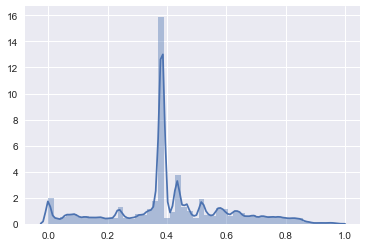

In [136]:
# spike is likely from members who are not cosponsors, or proposed ammendments
probs_dev = rfc.predict_proba(model_dev[features])[:,1]
probs_train = rfc.predict_proba(model_train[features])[:,1]
sns.distplot(probs_dev)

In [137]:
thresh = .75
print((probs_dev >= thresh).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= thresh, digits=4))

28824
             precision    recall  f1-score   support

          0     0.9581    0.9513    0.9546    454917
          1     0.2307    0.2599    0.2444     25595

avg / total     0.9193    0.9144    0.9168    480512



In [139]:
def export_predictions(dfs, model, file_name, 
                       path = "../data/model/model_predictions/", 
                       predictors = features):
    """Exports probabilities for all sets
    Args:
        dfs: train, dev, test sets. in that order.
        model: sklearn model to get predictions
        path: where to export
        predictors: Column set to use as predictors
    """
    labels = ['train', 'dev', 'test']
    for label, df in zip(labels, dfs):
        probs = model.predict_proba(df[predictors])[:,1]
        probs = pd.DataFrame(probs, index = df.full_set_id, columns=['pred_probs'])
        probs.to_csv(path + file_name + "_" + label + ".csv")

with open('../data/model/bill_involvement/rfc_involvement1.pickle', 'wb') as f:
    pickle.dump(rfc, f)
dfs = [model_train, model_dev, model_test]
export_predictions(dfs, rfc, 'bill_involvement', predictors=features)